In [1]:
import numpy as np
import pandas as pd
import glob
import os
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, MinMaxScaler


## Get Base Datasets

In [2]:
median_income_data_source = r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Rent Training Data\ACSDT5Y2022.B19013-Data.csv"

training_data_source = r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Redfin Data\rentals_0926.csv"

In [3]:
df = pd.read_csv(training_data_source)

df = df.rename(columns={
    # 'Max Square Feet': 'square_feet',
    # 'Max Beds': 'bedrooms',
    # 'Max Baths': 'bathrooms',
    'price': 'rent',
    'Latitude': 'latitude',
    'Longitude': 'longitude'
})

basic_metadata = ["property_id", "address", "city", "state"]
basic_features = ["square_feet", "bedrooms", "bathrooms"]
target = "rent"


for feature in basic_features + [target, "latitude", "longitude"]:
    df[feature] = pd.to_numeric(df[feature], errors='coerce')


df = df[(df["bedrooms"] > 0 ) 
        & (df["bedrooms"] < 6)  
        & (df["bathrooms"] < 4)  
        & (df["square_feet"] < 5000)  
        & (df["rent"] < 10000)  
        & (df["state_code"].notna()) 
        & (df["property_type"] == "6") 
    ]


## Get Median Income Dataset

In [8]:
#Get Median Income Data
median_income = pd.read_csv(median_income_data_source, skiprows=[1], na_values='-')

median_income['GEO_ID'] = median_income['GEO_ID'].astype(str)

# Extracting everything after "US" and storing it in a new column 'cbg_geoid'
median_income['cbg_geoid'] = median_income['GEO_ID'].str.extract('US(\d+)')
median_income['median_income'] = median_income['B19013_001E'].str.replace(',','+').str.replace('+','').str.replace('-','').astype(float)

median_income = median_income[["cbg_geoid", "median_income" ]]

print(df["property_id"].count())

df["cbg_geoid"] = df["cbg_geoid"].astype(str).str.split('.').str[0]
median_income["cbg_geoid"] = median_income["cbg_geoid"].astype(str)

df = df.merge(median_income, on='cbg_geoid', how="inner")

print(df["property_id"].count())

12854
12854


## One Hot for Beds and Baths

In [10]:
columns_to_encode = ['bedrooms', 'bathrooms']

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid dummy variable trap

# Fit and transform the data
encoded_features = encoder.fit_transform(df[columns_to_encode])

# Get feature names for the encoded columns
encoded_feature_names = encoder.get_feature_names_out(columns_to_encode)

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Concatenate the original DataFrame (excluding the original columns) with the encoded DataFrame
df = pd.concat([df, encoded_df], axis=1)

one_hot_features = encoded_feature_names.tolist()

## KNN Benchmark

In [31]:
import joblib

knn_features = ["latitude", "longitude"]
target = 'rent'

# List of different n values
n_values = [1, 5, 10]

# Convert latitude and longitude from degrees to radians for haversine metric
df_rad = np.radians(df[knn_features].values)

# Loop over different values of n
for n in n_values:
    # Create a new column for the benchmark rent for each n
    column_name = f'Rent_Benchmark_{n}_neighbors'
    df[column_name] = np.nan
    
    # Drop rows with missing values in the knn_features or target columns
    knn_df = df[knn_features + [target]].dropna()
    
    # Extract feature values and target values
    X = knn_df[knn_features].values
    y = knn_df[target].values
    
    # Convert latitude and longitude from degrees to radians for haversine metric
    X_rad = np.radians(X)
    
    # Initialize the KNeighborsRegressor with the haversine metric
    knn = KNeighborsRegressor(n_neighbors=n, metric='haversine')
    
    # Fit the KNN model
    knn.fit(X_rad, y)
    
    joblib.dump(knn, fr'C:\Users\mattl\OneDrive\Desktop\Projects\stoebebirch\Models\knn_model_{n}_neighbors.pkl')


    # Predict the average rent for each point in the original DataFrame
    df[column_name] = knn.predict(df_rad)

# Display the first few rows of the DataFrame with the new columns
benchmark_features = [f'Rent_Benchmark_{n}_neighbors' for n in n_values]

display(df[benchmark_features].head())

,Rent_Benchmark_1_neighbors,Rent_Benchmark_5_neighbors,Rent_Benchmark_10_neighbors
0,1000.0,1025.0,1305.0
1,1050.0,1030.0,1305.0
2,2500.0,1325.0,1305.0
3,1000.0,1035.0,1305.0
4,1050.0,1030.0,1305.0


In [25]:
import joblib
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor

# Assuming 'df' is your DataFrame and it's already loaded
# Example:
# df = pd.read_csv('your_data.csv')

knn_features = ["latitude", "longitude"]
target = 'rent'

# List of different n values
n_values = [1, 5, 10]  # You can adjust these as needed
max_n = max(n_values)

# Convert latitude and longitude from degrees to radians for haversine metric
df_rad = np.radians(df[knn_features].values)

# Drop rows with missing values in the knn_features or target columns
knn_df = df[knn_features + [target]].dropna()

# Extract feature values and target values
X = knn_df[knn_features].values
y = knn_df[target].values

# Convert latitude and longitude from degrees to radians for haversine metric
X_rad = np.radians(X)

# Initialize the KNeighborsRegressor with the haversine metric
# Set n_neighbors to max_n + 1 to account for excluding the point itself
knn = KNeighborsRegressor(n_neighbors=max_n *2, metric='haversine')

# Fit the KNN model
knn.fit(X_rad, y)

# Save the model if needed
# joblib.dump(knn, fr'C:\Users\mattl\OneDrive\Desktop\Projects\stoebebirch\Models\knn_model_{max_n}_neighbors.pkl')

# Find the neighbors for each point in the original DataFrame
distances, indices = knn.kneighbors(df_rad)

# Initialize dictionaries to hold rent benchmarks and average distances
rent_benchmarks = {n: [] for n in n_values}
average_distances = {n: [] for n in n_values}

# Iterate over each point's neighbors
for i in range(len(df)):
    # Extract distances and indices for the current point
    current_distances = distances[i]
    current_indices = indices[i]
    
    # Filter out neighbors with distance = 0 (self)
    valid_mask = current_distances > 0
    valid_distances = current_distances[valid_mask]
    valid_indices = current_indices[valid_mask]
    
    # If you have missing values in y_full, ensure alignment
    # Create a mapping from knn_df's indices to y
    # Since knn_df is a subset of df, we need to map original indices
    # Assuming df's index aligns with y_full
    # Otherwise, adjust accordingly
    neighbor_rents = y[knn_df.index.get_indexer(valid_indices)]
    
    for n in n_values:
        if len(neighbor_rents) >= n:
            selected_rents = neighbor_rents[:n]
            selected_distances = valid_distances[:n]
        else:
            # Handle cases where fewer than n neighbors are available
            selected_rents = neighbor_rents
            selected_distances = valid_distances
        # Compute average rent
        avg_rent = selected_rents.mean() if len(selected_rents) > 0 else np.nan
        rent_benchmarks[n].append(avg_rent)
        
        # Compute average distance in kilometers (haversine distance is in radians)
        # Earth's radius ≈ 6371 km
        avg_distance_km = selected_distances.mean() * 6371 if len(selected_distances) > 0 else np.nan
        average_distances[n].append(avg_distance_km)

# Add the computed benchmarks and distances to the DataFrame
for n in n_values:
    df[f'Rent_Benchmark_{n}_neighbors'] = rent_benchmarks[n]
    df[f'Average_Distance_{n}_neighbors'] = average_distances[n]

# Display the selected columns
display(df[basic_metadata+  benchmark_features + [target]].head(20))


,property_id,address,city,state,Rent_Benchmark_1_neighbors,Average_Distance_1_neighbors,Rent_Benchmark_5_neighbors,Average_Distance_5_neighbors,Rent_Benchmark_10_neighbors,Average_Distance_10_neighbors,rent
0,192795905,3902 S 284th Pl Unit 390,Auburn,WA,3275.0,0.823516,2807.0,1.273346,2568.4,2.048259,2000.0
1,192777962,3902 S 284th Pl Unit 21,Auburn,WA,3275.0,0.823516,2807.0,1.273346,2568.4,2.048259,2700.0
2,192795905,3902 S 284th Pl Unit 390,Auburn,WA,3275.0,0.823516,2807.0,1.273346,2568.4,2.048259,2000.0
3,192777962,3902 S 284th Pl Unit 21,Auburn,WA,3275.0,0.823516,2807.0,1.273346,2568.4,2.048259,2700.0
4,212002,4341 S 299th St,Auburn,WA,3275.0,0.827699,2650.0,1.133219,2439.5,1.552076,2995.0
5,212002,4341 S 299th St,Auburn,WA,3275.0,0.827699,2650.0,1.133219,2439.5,1.552076,2995.0
6,8188776,33708 42nd Ct S,Federal Way,WA,2350.0,2.759324,2648.0,3.004297,2812.5,3.501459,3295.0
7,8188776,33708 42nd Ct S,Federal Way,WA,2350.0,2.759324,2648.0,3.004297,2812.5,3.501459,3295.0
8,211486,3801 S 292nd Pl,Auburn,WA,2000.0,0.823516,2479.0,0.824352,2383.5,1.355673,3275.0
9,211486,3801 S 292nd Pl,Auburn,WA,2000.0,0.823516,2479.0,0.824352,2383.5,1.355673,3275.0


## Rescale Features

In [26]:
potential_features = ["median_income"] + one_hot_features + basic_features + benchmark_features

print(len(potential_features))

clean_df = df[basic_metadata + potential_features + [target]].dropna()

# display(clean_df)
# display(potential_features)

X_train, X_test, y_train, y_test = train_test_split(clean_df[potential_features], clean_df[[target]], train_size = .8, random_state=27)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.fit_transform(X_test)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

20


## Can we add Polynominals and Interactions

In [27]:
# only going to to leads to 324 Features. Up another level goes farther to like 9K
poly = PolynomialFeatures(degree = 2, include_bias=False)

X_train_poly = poly.fit_transform(X_train_scaled)

X_test_poly = poly.transform(X_test_scaled)

print("X_Train.shape: {}".format(X_train_scaled.shape))

print("X_Train_poly.shape: {}".format(X_train_poly.shape))


X_Train.shape: (9829, 20)
X_Train_poly.shape: (9829, 230)


In [30]:
from sklearn.linear_model import Ridge, Lasso

lr = LinearRegression().fit(X_train_scaled, y_train)
print("Linear Regression Score without Interations: {}".format(lr.score(X_test_scaled, y_test)))

#Causing Issues
# lr_interactions = LinearRegression().fit(X_train_poly, y_train)
# print("Linear Regression Score with Interations: {}".format(lr_interactions.score(X_test_poly, y_test)))

ridge = Ridge().fit(X_train_scaled, y_train)
print("Ridge Score without Interations: {}".format(ridge.score(X_test_scaled, y_test)))

ridge_interactions = Ridge().fit(X_train_poly, y_train)
print("Ridge Score with Interations: {}".format(ridge_interactions.score(X_test_poly, y_test)))

lasso = Lasso().fit(X_train_scaled, y_train)
print("Lasso Score without Interactions: {}".format(lasso.score(X_test_scaled, y_test)))

lasso_interactions = Lasso().fit(X_train_poly, y_train)
print("Lasso Score with Interations: {}".format(lasso_interactions.score(X_test_poly, y_test)))


Linear Regression Score without Interations: 0.5814463962111363
Ridge Score without Interations: 0.5899228305402124
Ridge Score with Interations: 0.6093228868361366
Lasso Score without Interactions: 0.5914744549352984
Lasso Score with Interations: 0.6034814438129219


## Explore Ridge With Interactions More

In [31]:
ridge_interactions = Ridge().fit(X_train_poly, y_train)


y_train_pred = ridge_interactions.predict(X_train_poly)

y_test_pred = ridge_interactions.predict(X_test_poly)

X_combined = pd.concat([X_train, X_test])
y_combined_pred = np.concatenate([y_train_pred, y_test_pred])
train_flag_combined = np.concatenate([np.ones(len(X_train)), np.zeros(len(X_test))])



401.93704410229157
0.6093228868361366


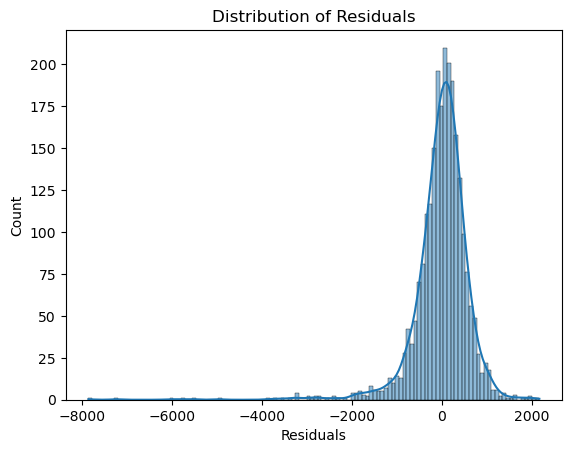

In [32]:
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(mae)
print(r2)

residuals = y_test_pred - y_test

sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()


## Feature Selection with Recursive Feature Eliminiation with Cross Val

In [33]:
from sklearn.feature_selection import RFECV

ridge = Ridge()

# Initialize RFECV with the Ridge model
rfecv = RFECV(estimator=ridge, step=1, cv=5, scoring='r2')

# Fit RFECV
rfecv.fit(X_train_poly, y_train)

# Number of features selected
print("Optimal number of features: %d" % rfecv.n_features_)


Optimal number of features: 128


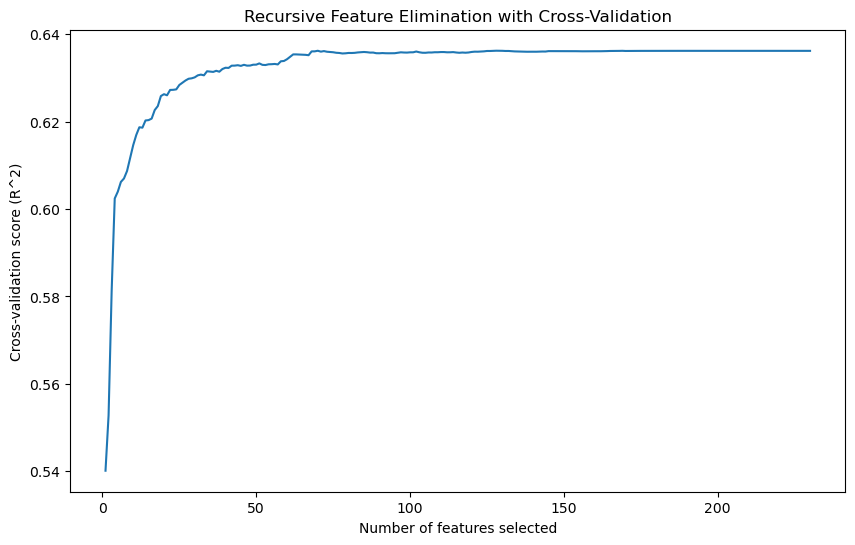

Selected features: ['median_income', 'bedrooms_5.0', 'bathrooms_2.0', 'bathrooms_2.5', 'bedrooms', 'Rent_Benchmark_1_neighbors', 'Average_Distance_1_neighbors', 'Rent_Benchmark_5_neighbors', 'Average_Distance_5_neighbors', 'Rent_Benchmark_10_neighbors', 'Average_Distance_10_neighbors', 'median_income^2', 'median_income bedrooms_2.0', 'median_income bedrooms_3.0', 'median_income bedrooms_4.0', 'median_income bedrooms_5.0', 'median_income bathrooms_1.0', 'median_income bathrooms_1.5', 'median_income bathrooms_2.0', 'median_income bathrooms_3.5', 'median_income square_feet', 'median_income bedrooms', 'median_income Rent_Benchmark_1_neighbors', 'median_income Average_Distance_1_neighbors', 'median_income Rent_Benchmark_5_neighbors', 'median_income Rent_Benchmark_10_neighbors', 'median_income Average_Distance_10_neighbors', 'bedrooms_2.0 bathrooms_2.0', 'bedrooms_2.0 bathrooms_2.5', 'bedrooms_2.0 bathrooms_3.0', 'bedrooms_2.0 square_feet', 'bedrooms_2.0 Rent_Benchmark_1_neighbors', 'bedroom

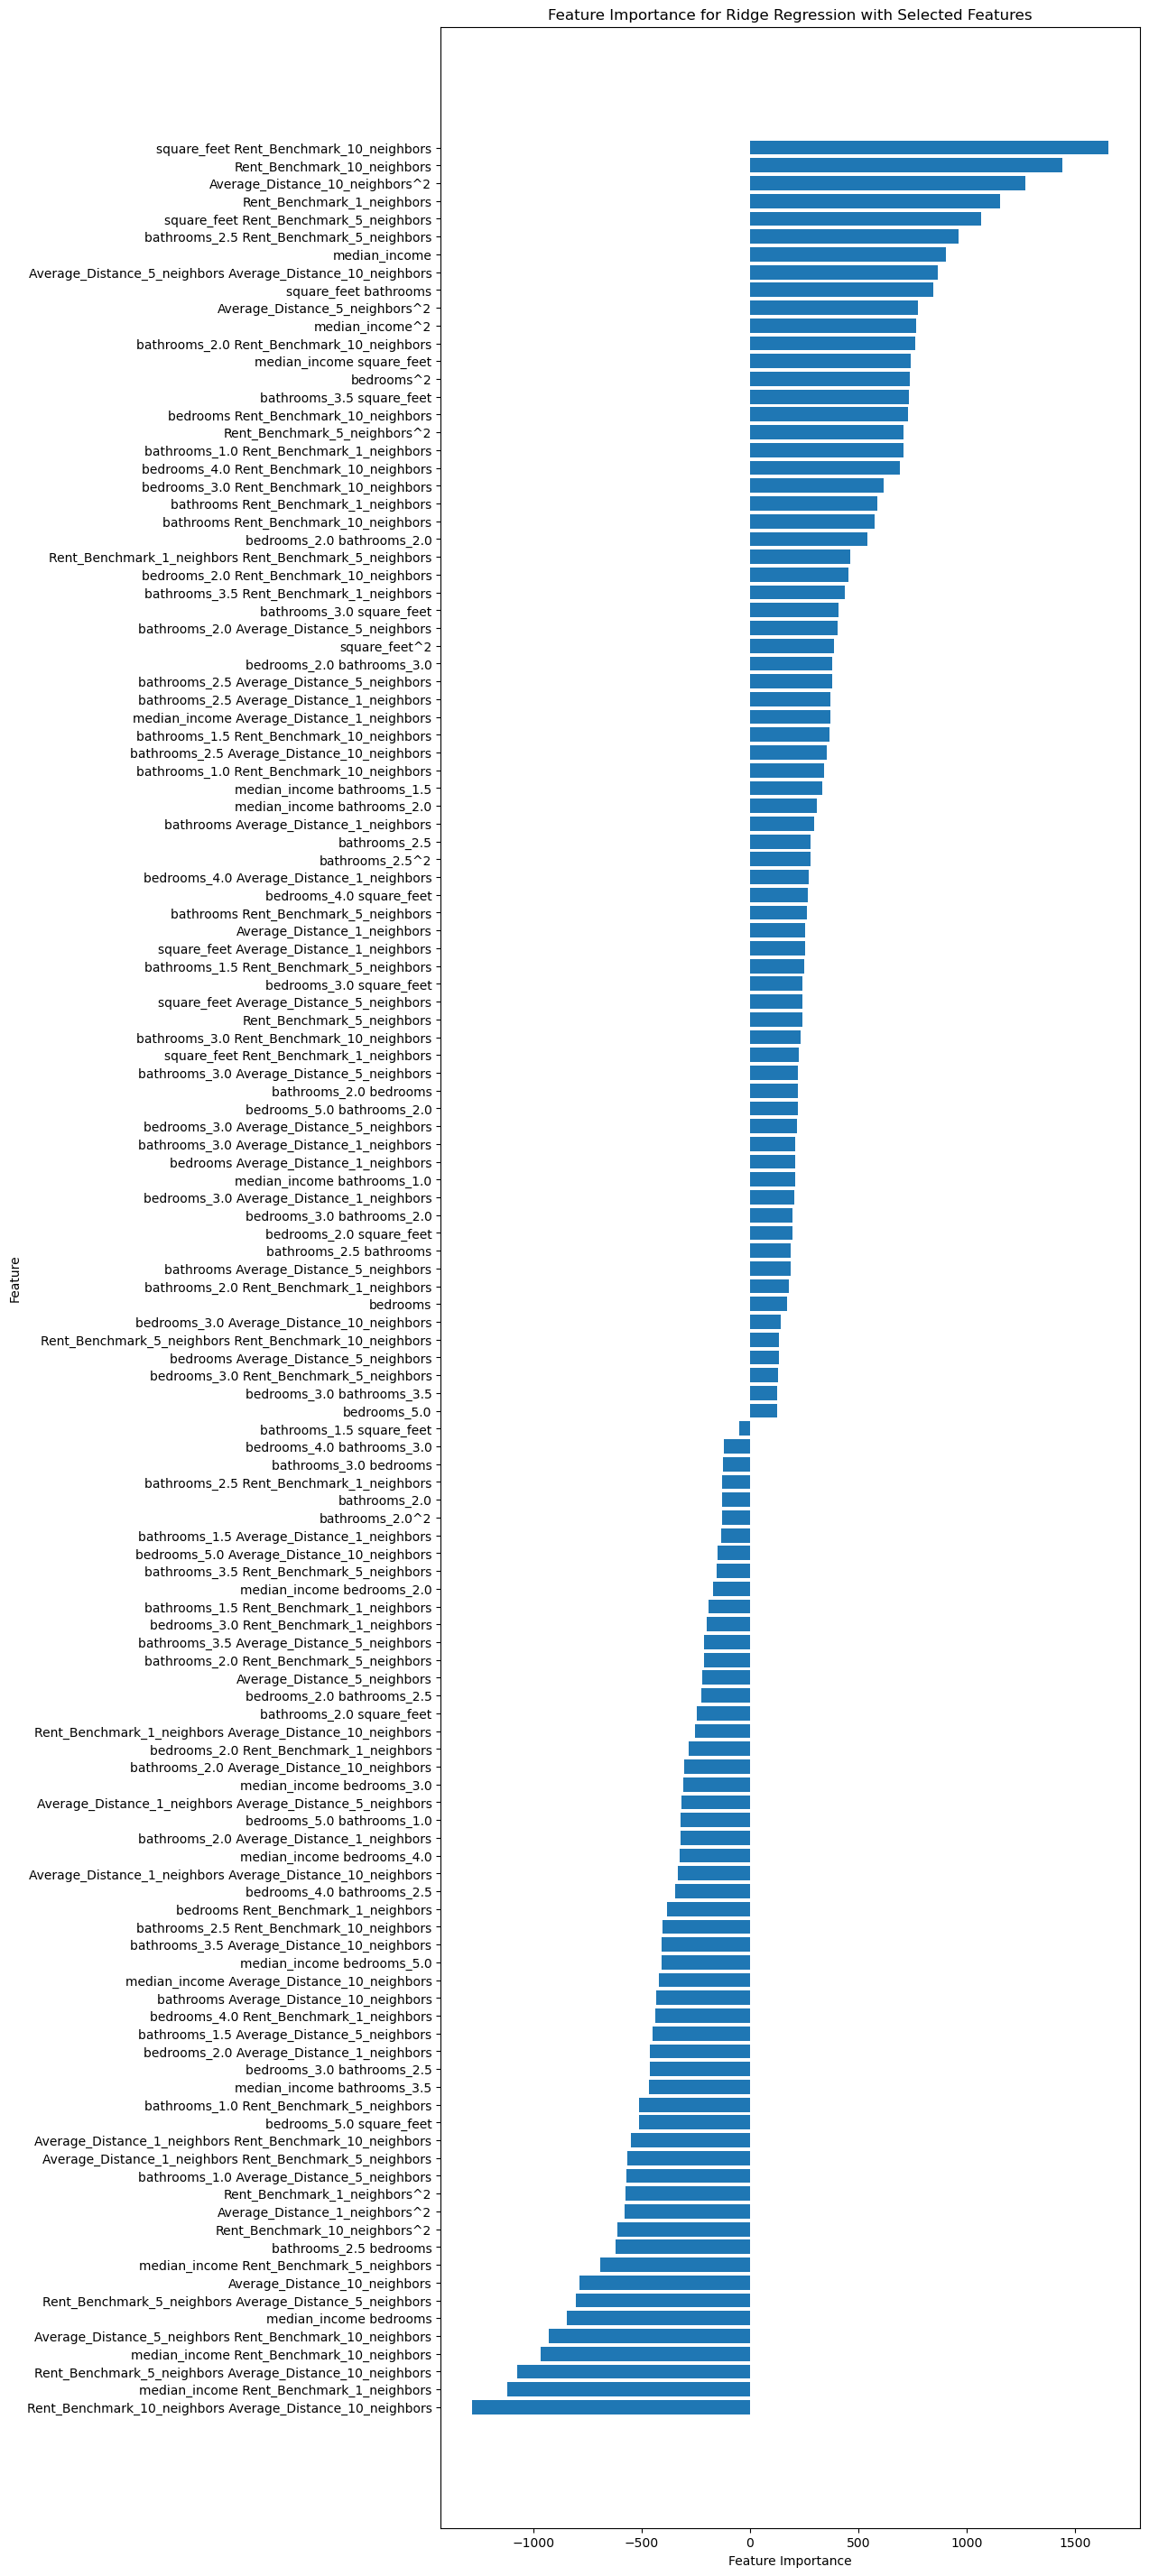

In [34]:

# Plot the number of features vs. cross-validation scores
plt.figure(figsize=(10, 6))
plt.title('Recursive Feature Elimination with Cross-Validation')
plt.xlabel('Number of features selected')
plt.ylabel('Cross-validation score (R^2)')
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

# Get the selected features mask
selected_features_mask = rfecv.support_

# Get the feature names
feature_names = poly.get_feature_names_out(potential_features)

# Get the selected features
selected_features = [feature for feature, selected in zip(feature_names, selected_features_mask) if selected]

# Print the selected features
print("Selected features:", selected_features)

# Transform the training and test sets to the optimal feature set
X_train_selected = rfecv.transform(X_train_poly)
X_test_selected = rfecv.transform(X_test_poly)

# Refit the model using the selected features
ridge.fit(X_train_selected, y_train)

# Evaluate the model
train_score = ridge.score(X_train_selected, y_train)
test_score = ridge.score(X_test_selected, y_test)

print("Train R^2 score with selected features: {:.4f}".format(train_score))
print("Test R^2 score with selected features: {:.4f}".format(test_score))

feature_importances = ridge.coef_

# Create a DataFrame for the feature importances
importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Print the feature importances
print(importance_df)

# Visualize the feature importances
plt.figure(figsize=(10, 36))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Ridge Regression with Selected Features')
plt.gca().invert_yaxis()
plt.show()

In [35]:

# Generate polynomial features for the entire dataset
X_scaled = scaler.transform(clean_df[potential_features])
X_poly = poly.transform(X_scaled)

# Select important features for the entire dataset
X_selected = rfecv.transform(X_poly)

# Create a new DataFrame with the original index and selected features
selected_feature_df = pd.DataFrame(X_selected, index=clean_df.index, columns=selected_features)

# Concatenate the new features with the original DataFrame
full_df = pd.concat([clean_df, selected_feature_df], axis=1)

# Display the new DataFrame
display(full_df)

,property_id,address,city,state,median_income,bedrooms_2.0,bedrooms_3.0,bedrooms_4.0,bedrooms_5.0,bathrooms_1.0,...,Rent_Benchmark_5_neighbors^2,Rent_Benchmark_5_neighbors Average_Distance_5_neighbors,Rent_Benchmark_5_neighbors Rent_Benchmark_10_neighbors,Rent_Benchmark_5_neighbors Average_Distance_10_neighbors,Average_Distance_5_neighbors^2,Average_Distance_5_neighbors Rent_Benchmark_10_neighbors,Average_Distance_5_neighbors Average_Distance_10_neighbors,Rent_Benchmark_10_neighbors^2,Rent_Benchmark_10_neighbors Average_Distance_10_neighbors,Average_Distance_10_neighbors^2
0,192795905,3902 S 284th Pl Unit 390,Auburn,WA,80129.0,0.0,0.0,1.0,0.0,0.0,...,0.101455,0.003965,0.093291,0.005710,0.000155,0.003646,0.000223,0.085784,0.005250,0.000321
1,192777962,3902 S 284th Pl Unit 21,Auburn,WA,80129.0,0.0,0.0,1.0,0.0,0.0,...,0.101455,0.003965,0.093291,0.005710,0.000155,0.003646,0.000223,0.085784,0.005250,0.000321
2,192795905,3902 S 284th Pl Unit 390,Auburn,WA,80129.0,0.0,0.0,1.0,0.0,0.0,...,0.101455,0.003965,0.093291,0.005710,0.000155,0.003646,0.000223,0.085784,0.005250,0.000321
3,192777962,3902 S 284th Pl Unit 21,Auburn,WA,80129.0,0.0,0.0,1.0,0.0,0.0,...,0.101455,0.003965,0.093291,0.005710,0.000155,0.003646,0.000223,0.085784,0.005250,0.000321
4,212002,4341 S 299th St,Auburn,WA,79728.0,0.0,0.0,1.0,0.0,0.0,...,0.086852,0.003264,0.080005,0.004003,0.000123,0.003007,0.000150,0.073698,0.003687,0.000184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12849,192104999,103 Franklin St,Darlington,IN,74821.0,0.0,1.0,0.0,0.0,1.0,...,0.011787,0.015645,0.012922,0.019478,0.020765,0.017151,0.025852,0.014166,0.021353,0.032185
12850,140926307,741 Shakamak Ct,Dayton,IN,57813.0,0.0,1.0,0.0,0.0,1.0,...,0.026983,0.009034,0.026322,0.009920,0.003024,0.008812,0.003321,0.025678,0.009677,0.003647
12851,142270938,5953 E Liberty Dr,Monticello,IN,114375.0,0.0,1.0,0.0,0.0,1.0,...,0.010890,0.037795,0.013208,0.038232,0.131176,0.045840,0.132694,0.016019,0.046370,0.134230
12852,118552901,516 W Darby Dr,Otterbein,IN,64583.0,0.0,1.0,0.0,0.0,1.0,...,0.031925,0.020816,0.031244,0.019052,0.013573,0.020372,0.012423,0.030577,0.018645,0.011370


In [44]:
selected_features = selected_feature_df.columns.tolist()

Ridge: Mean R^2 = 0.6416, Std = 0.0433
Lasso: Mean R^2 = 0.6352, Std = 0.0458


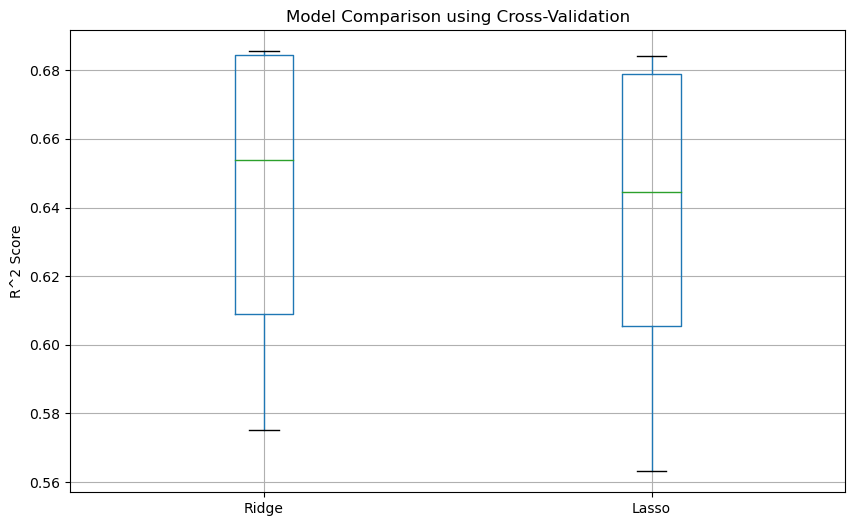

Best Model: Ridge
Test MAE: 400.6455
Test R^2: 0.6133


In [37]:
from sklearn.model_selection import cross_val_score


X_train_val, X_test, y_train_val, y_test = train_test_split(selected_feature_df, clean_df[[target]], train_size=0.8, random_state=27)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.8, random_state=27)


models = {
    # 'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    # 'Random Forest': RandomForestRegressor(n_estimators=100, random_state=27)
}

results = {}

for model_name, model in models.items(): 
    scores = cross_val_score(model, X_train, y_train, scoring = 'r2')
    results[model_name] = scores
    print(f"{model_name}: Mean R^2 = {scores.mean():.4f}, Std = {scores.std():.4f}")

results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
results_df.boxplot()
plt.title('Model Comparison using Cross-Validation')
plt.ylabel('R^2 Score')
plt.show()

# Optionally, train the best model on the combined training and validation set and evaluate on the test set
best_model_name = max(results, key=lambda k: results[k].mean())
best_model = models[best_model_name]
best_model.fit(X_train_val, y_train_val)

# Evaluate on the test set
y_test_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Best Model: {best_model_name}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R^2: {test_r2:.4f}")

## Because Ridge is best, we do not need to have a validation datset for fine tuning

In [38]:
#Check against validation Dataset

X_train, X_test, y_train, y_test = train_test_split(selected_feature_df, clean_df[[target]], train_size=0.9, random_state=27)


linear_model = Ridge()

linear_model.fit(X_train, y_train)

linear_model.predict(X_test)

array([[1710.49646435],
       [1554.0396659 ],
       [1852.65274919],
       ...,
       [2062.92571626],
       [1834.41207417],
       [2634.31436599]])

Cross-Validation R^2 Scores: [-1.78976347e+19  6.10295376e-01 -3.40584645e+18  6.26223090e-01
  4.73115005e-01]
Mean Cross-Validation R^2 Score: -4260696225098447360.0000
Cross-Validated Mean Absolute Error: 26468087026.4150
Cross-Validated R^2 Score: -4738414626803320832.0000
Final Model Mean Absolute Error: 386.4285
Final Model R^2 Score: 0.6463


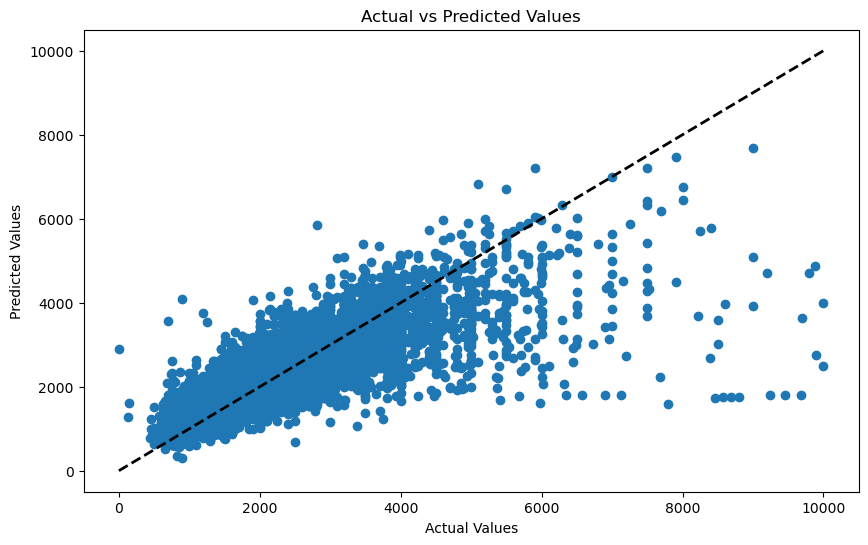

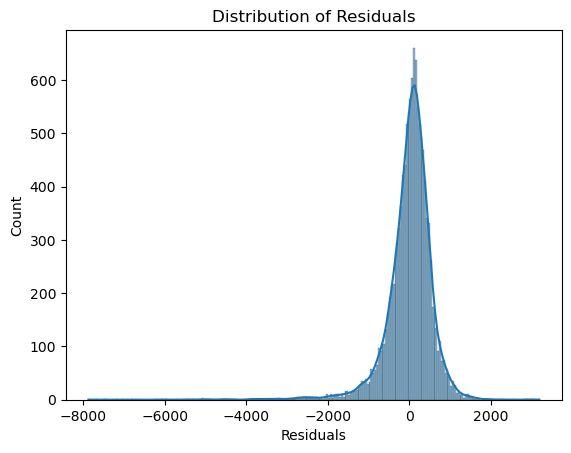

,property_id,address,city,state,median_income,bedrooms_2.0,bedrooms_3.0,bedrooms_4.0,bedrooms_5.0,bathrooms_1.0,...,bedrooms,bathrooms,Rent_Benchmark_1_neighbors,Average_Distance_1_neighbors,Rent_Benchmark_5_neighbors,Average_Distance_5_neighbors,Rent_Benchmark_10_neighbors,Average_Distance_10_neighbors,rent,Predicted_Rent
0,192795905,3902 S 284th Pl Unit 390,Auburn,WA,80129.0,0.0,0.0,1.0,0.0,0.0,...,4.0,3.0,3275.0,0.823516,2807.0,1.273346,2568.4,2.048259,2000.0,3553.486248
1,192777962,3902 S 284th Pl Unit 21,Auburn,WA,80129.0,0.0,0.0,1.0,0.0,0.0,...,4.0,3.0,3275.0,0.823516,2807.0,1.273346,2568.4,2.048259,2700.0,3553.486248
2,192795905,3902 S 284th Pl Unit 390,Auburn,WA,80129.0,0.0,0.0,1.0,0.0,0.0,...,4.0,3.0,3275.0,0.823516,2807.0,1.273346,2568.4,2.048259,2000.0,3553.486248
3,192777962,3902 S 284th Pl Unit 21,Auburn,WA,80129.0,0.0,0.0,1.0,0.0,0.0,...,4.0,3.0,3275.0,0.823516,2807.0,1.273346,2568.4,2.048259,2700.0,3553.486248
4,212002,4341 S 299th St,Auburn,WA,79728.0,0.0,0.0,1.0,0.0,0.0,...,4.0,2.5,3275.0,0.827699,2650.0,1.133219,2439.5,1.552076,2995.0,2618.553424


In [39]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Extract features and target variable
X = selected_feature_df
y = clean_df[target]

# Initialize the Linear Regression model
model = LinearRegression()

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R^2 Scores: {cv_scores}")
print(f"Mean Cross-Validation R^2 Score: {cv_scores.mean():.4f}")

# Get cross-validated predictions
cv_predictions = cross_val_predict(model, X, y, cv=5)

# Evaluate the model using cross-validated predictions
mae_cv = mean_absolute_error(y, cv_predictions)
r2_cv = r2_score(y, cv_predictions)

print(f"Cross-Validated Mean Absolute Error: {mae_cv:.4f}")
print(f"Cross-Validated R^2 Score: {r2_cv:.4f}")

# Train the final model on the entire dataset
model.fit(X, y)

# Make predictions on the entire dataset
predictions = model.predict(X)

# Add predictions to the original DataFrame
clean_df['Predicted_Rent'] = predictions

# Evaluate the final model
mae_final = mean_absolute_error(y, predictions)
r2_final = r2_score(y, predictions)

print(f"Final Model Mean Absolute Error: {mae_final:.4f}")
print(f"Final Model R^2 Score: {r2_final:.4f}")

# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.show()

# Visualize residuals
residuals = predictions - y
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

# Save the final model to a file
joblib.dump(model, 'single_family_rent_predictor.joblib')

# Display the DataFrame with the predictions
display(clean_df.head())


In [48]:
clean_df[basic_metadata + basic_features + ["median_income", "Rent", "Predicted_Rent"]].to_csv(r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Redfin Data\rentals_with_predictions.csv")

In [55]:
display(clean_df[basic_metadata + basic_features + ["median_income", "Rent", "Predicted_Rent"]])

,Property ID,Address,Square Feet,Bedrooms,Bathrooms,median_income,Rent,Predicted_Rent
0,191142853,1833 W Quinn Rd Unit B,1080.0,3,1.0,73015.0,1000.0,965.071241
1,191136919,1821 W Quinn Rd Unit A,1080.0,3,1.0,73015.0,1050.0,1018.399267
2,174553230,1805 Brock Dr,1550.0,3,2.0,73015.0,2500.0,2502.259044
3,191130680,1805 W Quinn Rd Unit A,1080.0,3,1.0,73015.0,1000.0,966.140097
4,191130550,1809 W Quinn Rd Unit D,1080.0,3,1.0,73015.0,1050.0,1018.399267
...,...,...,...,...,...,...,...,...
54414,17789180,24 Ashbury Ln,3840.0,4,2.5,215331.0,4500.0,4609.858676
54415,13906013,116 Coolidge Ave,875.0,2,1.0,122841.0,2850.0,2761.128515
54416,17650257,20055 Ela Rd,3804.0,4,3.0,235347.0,4995.0,5098.271368
54417,57971213,14225 Ranch Rd,1520.0,3,1.0,130208.0,2500.0,2527.909892
